In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import json

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Activation, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# If you have more than 1 GPU, you might want to specify which GPU for training.
# In this case, I have 2 GPU and the second one is RTX 2080ti, so I pick the `second` one.
os.environ['CUDA_VISIBLE_DEVICES']='1' # The second
tf.config.set_soft_device_placement(True)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Constants

In [2]:
d_name = '20210925_wmt19_en_zh'
folder_name = '20210925_translate_mle_en_zh'

wv_dim = 32
encoder_que_pad = 35
decoder_que_pad = 32

# Load data

In [3]:
encoder_train = pickle.load(open(f'{d_name}/encoder_train.pkl', 'rb'))
decoder_train = pickle.load(open(f'{d_name}/decoder_train.pkl', 'rb'))
teacher_train = pickle.load(open(f'{d_name}/teacher_train.pkl', 'rb'))
encoder_vali  = pickle.load(open(f'{d_name}/encoder_vali.pkl', 'rb'))
decoder_vali  = pickle.load(open(f'{d_name}/decoder_vali.pkl', 'rb'))
teacher_vali  = pickle.load(open(f'{d_name}/teacher_vali.pkl', 'rb'))

decoder_idx2word   = pickle.load(open(f'{d_name}/en_idx2word.pkl','rb'))
decoder_word2idx   = pickle.load(open(f'{d_name}/en_word2idx.pkl','rb'))
encoder_idx2word   = pickle.load(open(f'{d_name}/zh_idx2word.pkl','rb'))
encoder_word2idx   = pickle.load(open(f'{d_name}/zh_word2idx.pkl','rb'))

decoder_emb32    = pickle.load(open(f'{d_name}/en_emb32.pkl', 'rb'))
encoder_emb32    = pickle.load(open(f'{d_name}/zh_emb32.pkl', 'rb'))

In [4]:
num_decoder_words = np.max([np.max(decoder_train), np.max(decoder_vali)])+1
num_encoder_words = np.max([np.max(encoder_train), np.max(encoder_vali)])+1

print(num_decoder_words)
print(num_encoder_words)

57298
75420


In [5]:
def seq2word(seq_tensor, idx2word):
    return np.array([[idx2word[str(i)] for i in seq] for seq in seq_tensor])

In [8]:
seq2word(decoder_vali[:1], decoder_idx2word)

array([['<bos>', '1929', 'or', '1989', '<eos>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>']], dtype='<U5')

In [7]:
seq2word(encoder_vali[:1], encoder_idx2word)

array([['1929', '年', '还是', '1989', '年', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
        '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']],
      dtype='<U5')

# Positional Encoding
[Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [9]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10, 64)


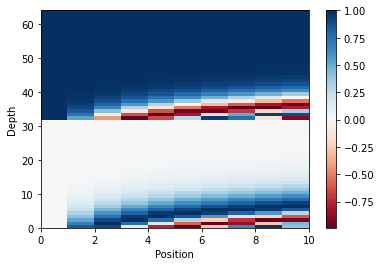

In [10]:
from matplotlib import pyplot as plt
n, d = 10, 64
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Generator

[Multi-Head Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 
and [Positional Encoding](https://www.tensorflow.org/text/tutorials/transformer)
based on [Vaswani+17, Attention is All You Need](https://arxiv.org/abs/1706.03762)

In [11]:
def Transformer(q_que_pad, k_que_pad, wv_dim, rate = 0.1, mask = ''):
    # Inputs
    mem  = Input((q_que_pad, wv_dim))
    encode = Input((k_que_pad, wv_dim))
    # Constants
    ff_dim = wv_dim*16
    # Multi-Head Attention
    q = Dense(wv_dim)(mem)
    k = Dense(wv_dim)(encode)
    v = Dense(wv_dim)(encode)
    # Choose a mask, default: BERT (no mask)
    mask_weights = np.ones((q_que_pad, k_que_pad))
    if mask == 'GPT':
        mask_weights = np.tri(q_que_pad, k_que_pad, 0)
    mem_new = MultiHeadAttention(
        num_heads = 4,
        key_dim = wv_dim, 
        value_dim = wv_dim
    )(
        q, k, v,
        attention_mask = mask_weights
    )
    mem_new = Dropout(rate)(mem_new)
    mem_new = LayerNormalization(epsilon=1e-6)(mem_new+mem)
    # Feed-Forward skip-connection
    ffn = Dense(ff_dim, activation = 'relu')(mem_new)
    ffn = Dense(wv_dim)(ffn)
    ffn = Dropout(rate)(ffn)
    out = LayerNormalization(epsilon=1e-6)(ffn+mem_new)
    model = Model(
        [mem, encode],
        [mem_new, out],
    )
    return model

def getE():
    _input = Input((encoder_que_pad,))
    emb = Embedding(
        num_encoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(encoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(encoder_emb32),
    )
    mem = emb(_input)
    # position encoding
    pe = positional_encoding(encoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # forward sentence
    for i in range(1):
        gptLayer = Transformer(encoder_que_pad, encoder_que_pad, wv_dim)
        mem, output = gptLayer((mem, mem))
        output = Activation('relu')(output)
        mem = Activation('relu')(mem)
    # Output
    model = Model(
        _input, 
        output) 
    return model

def getD():
    en_output = Input((encoder_que_pad, wv_dim))
    de_input  = Input((decoder_que_pad,))
    emb = Embedding(
        num_decoder_words, 
        wv_dim, 
        mask_zero = False,
        input_length=(int(decoder_que_pad)),
        trainable = True,
        embeddings_initializer=tf.keras.initializers.Constant(decoder_emb32),
    )
    mem = emb(de_input)
    # position encoding
    pe = positional_encoding(decoder_que_pad, wv_dim)
    mem = LayerNormalization(epsilon=1e-6)(mem+pe)
    # Attention
    for j in range(1):
        # Self attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, decoder_que_pad, wv_dim, mask = 'GPT')
            mem, _ = gptLayer((mem, mem))
            mem = Activation('relu')(mem)
        # Cross attention
        for i in range(1):
            gptLayer = Transformer(decoder_que_pad, encoder_que_pad, wv_dim)
            mem, output = gptLayer((mem, en_output))
            output = Activation('relu')(output)
            mem = Activation('relu')(mem)
    # Concatenation and output
    output = Dense(num_decoder_words)(output)
    output = Activation('softmax')(output)
    model = Model(
        [en_output, de_input], 
        output,
    )
    return model

# Language Model
def getLM():
    # Inputs
    en_input = Input((encoder_que_pad,))
    de_input = Input((decoder_que_pad,))
    # Encoder (Czech -> code)
    encoder = getE()
    en_output = encoder(en_input)
    # Decoder (code -> English)
    decoder = getD()
    de_output = decoder([en_output, de_input])
    # Establish the model
    model = Model(
        [en_input, de_input],
        de_output,
    )
    return model

In [12]:
mleG = getLM()
mleG.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)
mleG.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 35, 32)       2466912     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 32, 57298)    3831250     model_1[0][0]                    
                                                                 input_2[0][0]              

In [14]:
mleG.fit(
    [encoder_train, decoder_train], 
    teacher_train, 
    batch_size=64, 
    epochs=300, 
    shuffle=True, 
    validation_data = (
        [encoder_vali, decoder_vali], 
        teacher_vali
    ), 
    callbacks=[
        ModelCheckpoint(
            f'./{folder_name}/mleG.h5', 
            save_best_only=True, 
            monitor = "val_loss"
        ),
        EarlyStopping(monitor='val_loss', patience=5),
        CSVLogger(f'{folder_name}/mleG.csv'),
    ]
)

Epoch 1/300
3403/3403 [==============================] - 391s 114ms/step - loss: 3.7161 - accuracy: 0.5202 - val_loss: 3.0375 - val_accuracy: 0.5584
Epoch 2/300
3403/3403 [==============================] - 386s 113ms/step - loss: 2.9183 - accuracy: 0.5650 - val_loss: 2.7996 - val_accuracy: 0.5808
Epoch 3/300
3403/3403 [==============================] - 387s 114ms/step - loss: 2.7013 - accuracy: 0.5829 - val_loss: 2.6502 - val_accuracy: 0.5966
Epoch 4/300
3403/3403 [==============================] - 387s 114ms/step - loss: 2.5480 - accuracy: 0.5968 - val_loss: 2.5585 - val_accuracy: 0.6075
Epoch 5/300
3403/3403 [==============================] - 384s 113ms/step - loss: 2.4379 - accuracy: 0.6070 - val_loss: 2.5037 - val_accuracy: 0.6149
Epoch 6/300
3403/3403 [==============================] - 382s 112ms/step - loss: 2.3539 - accuracy: 0.6149 - val_loss: 2.4635 - val_accuracy: 0.6203
Epoch 7/300
3403/3403 [==============================] - 388s 114ms/step - loss: 2.2853 - accuracy: 0.6215

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
mleG.load_weights(f'./{folder_name}/mleG.h5')
loss, _acc = mleG.evaluate(
    [encoder_vali, decoder_vali], 
    teacher_vali
)
print(loss)

757/757 [==============================] - 49s 65ms/step - loss: 2.3838 - accuracy: 0.6357
2.38375186920166


## Inference train D (False) 

In [18]:
def inference(
    model,
    enData = None,
):
    # Initialize
    resp_pred_list = None
    in_batch_list = None
    the_first = True
    
    in_batch = np.zeros((len(enData), decoder_que_pad), dtype = int)
    in_batch[:,0] = decoder_word2idx['<bos>']
    en_batch = enData
    resp_pred = np.zeros(in_batch.shape, dtype = int)
    # Generate the sequence recurrsively.
    for i in range(decoder_que_pad):
        # Run
        resp_pred_wv = model([en_batch, in_batch])
        the_last = resp_pred_wv[:,i]
        the_last = tf.reshape(
            tf.random.categorical(tf.math.log(the_last), 1), 
            [len(enData),]
        )
        try:
            resp_pred[:,i] = the_last
            in_batch[:,i+1] = the_last
        except:
            resp_pred[:,i] = the_last
    # Remove the words after <eos>
    for i in range(len(resp_pred)):
        try:
            index = list(resp_pred[i]).index(en_word2idx['<eos>'])
        except:
            continue
        resp_pred[i,index+1:] = 0
        in_batch[i,index+1:] = 0
        
    return resp_pred, in_batch

In [22]:
resp_pred_list, _ = inference(mleG, [encoder_vali[99]])
print('# Predicted sequence')
print(seq2word(resp_pred_list, decoder_idx2word))
print('# Real sequence')
print(seq2word([decoder_vali[99]], decoder_idx2word))

# Predicted sequence
[['most' 'surprises' 'will' 'be' 'two' 'parties' 'turkish' 'and' 'the'
  'eu' 'and' 'the' 'eu' 'still' 'struggle' 'against' 'israel' 'and'
  'turkey’s' 'israeli' 'country' 'and' 'european' 'union' 'they' '<eos>'
  '<pad>' '<pad>' '<pad>' '<pad>' '<pad>' '<pad>']]
# Real sequence
[['<bos>' 'but' 'it' 'is' 'nothing' 'if' 'not' 'surprising' 'that'
  'these' 'parties' 'and' 'not' 'the' 'us' 'and' 'the' 'european' 'union'
  'would' 'be' 'negotiating' 'such' 'an' 'agreement' '<eos>' '<pad>'
  '<pad>' '<pad>' '<pad>' '<pad>' '<pad>']]
